# Day cloud phase RGB (RGB example using non-reprojected VIS and IR channels)
This jupyter notebook shows how to make a sub-region plot of Day cloud phase RGB composition. This is an example of RGB composition using non-reprojected VIS and IR channels of GOES-16. \
**Warning: if your RAM is less than 8GB it is recommended to work with a small domain.**

Import the GOES package.

In [1]:
import GOES

Set path and name of file that will be read.

In [2]:
path = '/home/joao/Downloads/GOES-16/ABI/'
C02_file = 'OR_ABI-L2-CMIPF-M6C02_G16_s20210331700146_e20210331709454_c20210331709523.nc'
C05_file = 'OR_ABI-L2-CMIPF-M6C05_G16_s20210331700146_e20210331709454_c20210331709532.nc'
C13_file = 'OR_ABI-L2-CMIPF-M6C13_G16_s20210331700146_e20210331709465_c20210331709558.nc'

Reads the file.

In [3]:
C02_ds = GOES.open_dataset(path+C02_file)
C05_ds = GOES.open_dataset(path+C05_file)
C13_ds = GOES.open_dataset(path+C13_file)

Set the map domain.

In [4]:
domain = [-90.0,-30.0,-60.0,15.0]

Gets image with the coordinates of center of their pixels.

In [5]:
C13, _, _ = C13_ds.image('CMI', lonlat='center', domain=domain)

Gets the **pixels_limits** parameter of C13. This parameter will be used in the other channels to obtain an imagen with the same domain than C13.

In [6]:
domain_in_pixels = C13.pixels_limits

Because the spatial resolution of channel 05 is 1.0 km and channel 13 is 2.0 km, it is necessary to **double** the **domain_in_pixels** values to obtain an image of **channel 05** with the same coverage area as **channel 13**.

In [7]:
C05_domain_in_pixels = [domain_in_pixels[0]*2, (domain_in_pixels[1]+1)*2-1,
                        domain_in_pixels[2]*2, (domain_in_pixels[3]+1)*2-1]

Creates a mask that identifies the nan values of C13. This mask will be used to obtain the image of channel 05.

In [8]:
import numpy as np
mask = np.where(np.isnan(C13.data)==True, True, False)

Repeats each element of the mask two times to match with the image size of channel 05.

In [9]:
C05_mask = np.kron(mask, np.ones((2,2), dtype=mask.dtype))

Gets the image of channel 05 with the same coverage area as channel 13.

In [10]:
C05, LonCen, LatCen = C05_ds.image('CMI', lonlat='center',
                                   domain_in_pixels=C05_domain_in_pixels, nan_mask=C05_mask)

Since the spatial resolution of channel 02 is 0.5 km and channel 13 is 2.0 km, is necessary to **quadruple** the **domain_in_pixels** values to obtain an image of **channel 01** with the same coverage area as **channel 13**.

In [11]:
C02_domain_in_pixels = [domain_in_pixels[0]*4, (domain_in_pixels[1]+1)*4-1,
                        domain_in_pixels[2]*4, (domain_in_pixels[3]+1)*4-1]

Repeats each element of the mask four times to match with the image size of channel 02.

In [12]:
C02_mask = np.kron(mask, np.ones((4,4), dtype=mask.dtype))

Gets the image of channel 02 with the same coverage area as channel 01.

In [13]:
C02, _, _ = C02_ds.image('CMI', lonlat='none', domain_in_pixels=C02_domain_in_pixels, nan_mask=C02_mask)

Deletes unnecessary arrays.

In [14]:
del domain_in_pixels, mask
del C05_domain_in_pixels
del C02_domain_in_pixels, C02_mask

The spatial resolution of C02, C05 y C13 is 0.5 Km, 1.0 Km and 2.0 Km respectively, for this reason the size of C05 is twice the size of C13 and the size of C02 is twice the size of C05. To solve this problem we are going to repeat each pixel in C13 twice and reduce the number of pixels in C02 by averaging groups of 4 pixels (2 on the y axis and 2 on the x axis). This way, C02 and C13 will have the same size as C05.

In [15]:
# repeat pixels of C13
C13.data = np.kron(C13.data, np.ones((2,2), dtype=C13.data.dtype))

# averaging pixels of C02
nx, ny = 2, 2
ysize, xsize = C02.data.shape
C02.data = np.mean(C02.data.reshape((int(ysize/ny),ny,int(xsize/nx),nx)), axis=(1,3))

Gets information about data.

In [16]:
sat = C13_ds.attribute('platform_ID')
time = C13_ds.variable('time_bounds').data[0]

Defines the name of product.

In [17]:
product = 'Day snow-fog RGB'

Calculates the cosine of zenith angle.

In [18]:
cosz = GOES.cosine_of_solar_zenith_angle(LonCen.data, LatCen.data, time)

Calculates the coordinates of corners of pixels.

In [19]:
LonCor, LatCor = GOES.calculate_corners(LonCen, LatCen)

Deletes the coordinates of centers of pixels since they will no longer be used.

In [20]:
del LonCen, LatCen

Makes the RGB composition.

In [21]:
# converts reflectance factor of channel 01, 02 and 03 to reflectance and save them as R, G and B
R = C13.data - 273.15
G = C02.data/cosz.data
B = C05.data/cosz.data

# set limits of channels
Rmin, Rmax = -53.5, 7.5
Gmin, Gmax = 0.0, 0.78
Bmin, Bmax = 0.1, 0.59
R = np.clip(R, Rmin, Rmax)
G = np.clip(G, Gmin, Gmax)
B = np.clip(B, Bmin, Bmax)

# normalize channels
R = (R-Rmin)/(Rmax-Rmin)
G = (G-Gmin)/(Gmax-Gmin)
B = (B-Bmin)/(Bmax-Bmin)

# perfoms a gamma correction
gamma = 1.0
R = np.power(R, 1/gamma)
G = np.power(G, 1/gamma)
B = np.power(B, 1/gamma)

# invert the channel
R = 1.0 - R

# stack channels
RGB = np.dstack((R, G, B)).astype(np.float16)

# reshape RGB to 1-D array
RGB = RGB.reshape((RGB.shape[0]*RGB.shape[1],RGB.shape[2]))

# ensures RGB data is between 0 and 1
RGB = np.clip(RGB, 0.0, 1.0, dtype=RGB.dtype)

# creates a simple array to make the plot with pcolormesh
mask = np.where(C05_mask==True,np.nan, 1).astype(np.float16)

Deletes unnecessary data.

In [22]:
del C13, C02, C05, cosz, R, G, B, C05_mask

Creates plot.

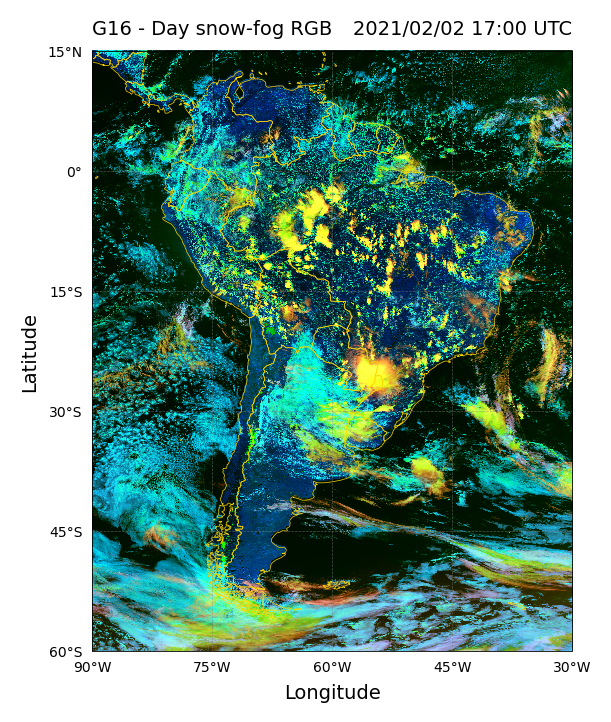

In [23]:
# import packages
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter

# calculates the central longitude of the plot
lon_cen = 360.0+(domain[0]+domain[1])/2.0

# creates the figure
fig = plt.figure('map', figsize=(4,4), dpi=200)
ax = fig.add_axes([0.1, 0.16, 0.80, 0.75], projection=ccrs.PlateCarree(lon_cen))
ax.outline_patch.set_linewidth(0.3)

# add the geographic boundaries
l = NaturalEarthFeature(category='cultural', name='admin_0_countries', scale='50m', facecolor='none')
ax.add_feature(l, edgecolor='gold', linewidth=0.25)

# plot the data
img = ax.pcolormesh(LonCor.data, LatCor.data, mask, transform=ccrs.PlateCarree(), color=RGB)

# set the title
ax.set_title('{} - {}'.format(sat, product), fontsize=7, loc='left')
ax.set_title(time.strftime('%Y/%m/%d %H:%M UTC'), fontsize=7, loc='right')

# Sets X axis characteristics
dx = 15
xticks = np.arange(domain[0], domain[1]+dx, dx)
ax.set_xticks(xticks, crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter(dateline_direction_label=True))
ax.set_xlabel('Longitude', color='black', fontsize=7, labelpad=3.0)

# Sets Y axis characteristics
dy = 15
yticks = np.arange(domain[2], domain[3]+dy, dy)
ax.set_yticks(yticks, crs=ccrs.PlateCarree())
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.set_ylabel('Latitude', color='black', fontsize=7, labelpad=3.0)

# Sets tick characteristics
ax.tick_params(left=True, right=True, bottom=True, top=True,
               labelleft=True, labelright=False, labelbottom=True, labeltop=False,
               length=0.0, width=0.05, labelsize=5.0, labelcolor='black')

# Sets grid characteristics
ax.gridlines(xlocs=xticks, ylocs=yticks, alpha=0.6, color='gray',
             draw_labels=False, linewidth=0.25, linestyle='--')

# set the map limits
ax.set_extent([domain[0]+360.0, domain[1]+360.0, domain[2], domain[3]], crs=ccrs.PlateCarree())

plt.show()